# <span style="color:#1f77b4; font-weight:bold; font-family:Helvetica">Simulation Based Inference for Ion Implantation</span>

 <span style="color:#white; font-weight:bold; font-family:Helvetica">Chinmay Bharathulwar</span>

Using SRIM simulations + SBI to infer ion energy from recoil tracks

## Setup




In [ ]:
#Import all necessary libraries and dependencies
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import random
import shutil
import os
from sbi.utils import BoxUniform
from srim import TRIM, Ion, Layer, Target
import os, re, math
from typing import Dict, List

## Data Preprocessing 

In [ ]:
# import raw data and group by ion and energy
data_path = '../data/all_vacancies.csv'
df = pd.read_csv(data_path)
df.columns = ["x", "y", "z", "ion", "energy"]
grouped = df.groupby(["ion", "energy"])

In [ ]:
#set up x_obs and theta
x_obs = []
theta = []

for (ion, energy), group in grouped:
    # group is a mini-DataFrame with all rows that share this ion + energy


    track = group[["x", "y", "z"]].values  # → shape (n_points, 3)

    # Summarize this track (e.g., mean and std of z)
    mean_x = np.mean(track[:, 0])
    std_x = np.std(track[:, 0])
    num_vac = track.shape[0]


    x_obs.append([mean_x, std_x, num_vac])  # Feature vector for this track
    theta.append([energy])  # Just using energy for now
    

In [ ]:
#convert to tensor
x_obs = torch.tensor(x_obs, dtype=torch.float32)
theta = torch.tensor(theta, dtype=torch.float32)

## Simulation Based Inference

In [ ]:
#set up prior 
low = torch.tensor([1000.0])
high = torch.tensor([2000000.0])
prior = BoxUniform(low, high)

In [ ]:
#set up infernece object
from sbi.inference import NPE
inference = NPE(prior=prior, density_estimator="nsf")

In [ ]:
#train nn 
posterior_net = inference.append_simulations(theta, x_obs).train()

 Neural network successfully converged after 145 epochs.

In [ ]:
#create usable posterior object
posterior = inference.build_posterior()

## Posterior Predictive Checks (PPC)

In [ ]:
#define paramater used to perform PPC and find theta distribution
x_test = x_obs[0:1]

In [ ]:
#find 1000 thetas using posterior object 
samples = posterior.sample((1000,), x_test)

In [ ]:
#define functions for running PySRIM and saving data for some numumber of thetas

# All the files we typically want to archive from a TRIM run
KNOWN_TXT_OUTPUTS = [
    "TDATA.txt", "RANGE.txt", "VACANCY.txt", "IONIZ.txt",
    "PHONON.txt", "E2RECOIL.txt", "NOVAC.txt", "LATERAL.txt"
]
ALSO_COPY = ["TRIM.IN", "TRIMAUTO"]  # not tables, but useful for audit

def run_srim_for_theta(theta_eV,
                       srim_directory,
                       output_base,
                       ion_symbol="C",
                       number_ions=200,
                       calculation=1,
                       layer_spec=None,
                       density_g_cm3=3.51,
                       width_A=15000.0,
                       overwrite=False):
    """
    Run SRIM at a given energy and save results to a unique folder.

    Parameters
    ----------
    theta_eV : float
        Ion energy in eV (e.g., 1e3 for 1 keV).
    srim_directory : str
        Path to the SRIM-2013 directory (where TRIM.exe lives).
    output_base : str
        Base directory under which a unique folder per theta will be created.
    ion_symbol : str
        Element symbol for the ion (default: "C").
    number_ions : int
        Number of ions to simulate (default: 200).
    calculation : int
        TRIM calculation mode (1 = quick KP).
    layer_spec : dict|None
        Layer element dict; default is pure Carbon with E_d=30 eV, etc.
    density_g_cm3 : float
        Layer density (default: 3.51 g/cm^3, graphite-like).
    width_A : float
        Layer thickness in Å (default: 15000 Å = 1.5 μm).
    overwrite : bool
        If True, delete an existing theta folder before writing.

    Returns
    -------
    output_dir : str
        Path to the unique folder containing this run’s outputs.
    """
    srim_dir = Path(srim_directory)
    out_base = Path(output_base)

    # Folder name: theta_<energy in eV, rounded>
    theta_tag = f"theta_{int(round(float(theta_eV)))}"
    out_dir = out_base / theta_tag
    if out_dir.exists() and overwrite:
        shutil.rmtree(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Clean old outputs from the SRIM directory so we only copy fresh files
    for name in KNOWN_TXT_OUTPUTS + ALSO_COPY:
        p = srim_dir / name
        if p.exists():
            p.unlink()

    # Default layer: pure Carbon, adjust if you use a different target
    if layer_spec is None:
        layer_spec = {'C': {'stoich': 1.0, 'E_d': 30.0, 'lattice': 0.0, 'surface': 3.0}}

    # Build ion/target and run TRIM
    ion = Ion(ion_symbol, energy=float(theta_eV))
    layer = Layer(layer_spec, density=density_g_cm3, width=width_A)
    target = Target([layer])

    trim = TRIM(target, ion, number_ions=number_ions, calculation=calculation)
    trim.run(str(srim_dir))  # writes outputs directly into srim_directory

    # Copy fresh outputs from SRIM-2013 into the unique theta folder
    copied = []
    for name in KNOWN_TXT_OUTPUTS + ALSO_COPY:
        src = srim_dir / name
        if src.exists():
            shutil.copy2(src, out_dir / name)
            copied.append(name)

    # Sanity check: if TDATA.txt isn't there, the run likely failed
    if "TDATA.txt" not in copied:
        raise RuntimeError(
            f"SRIM run at {theta_eV} eV produced no TDATA.txt in {srim_dir}. "
            f"Copied files: {copied}"
        )

    return str(out_dir)


def run_srim_batch(thetas_eV,
                   srim_directory,
                   output_base,
                   **kwargs):
    """
    Run SRIM for many energies and save each run to its own folder.

    Returns
    -------
    runs : list[tuple(float, str)]
        List of (theta_eV, output_folder) pairs in the same order as input.
    """
    results = []
    for theta in thetas_eV:
        print(f"[SRIM] Running theta = {theta} eV ...")
        folder = run_srim_for_theta(theta, srim_directory, output_base, **kwargs)
        print(f"[SRIM]   → saved to: {folder}")
        results.append((theta, folder))
    return results

In [ ]:
#using functions and run SRIM for 50 random thetas from predicted thetas
srim_dir   = "/Users/cbharathulwar/Documents/Research/Walsworth/SRIM-2013"
outputs_to = "/Users/cbharathulwar/Documents/Research/Walsworth/SRIM-2013/Outputs"

thetas =thetas = samples.detach().cpu().numpy().flatten().tolist()
thetas = random.sample(thetas, 50)

runs = run_srim_batch(
    thetas,
    srim_directory=srim_dir,
    output_base=outputs_to,
    ion_symbol="C",
    number_ions=200,   # bump to 500–1000 later if you need lower noise
    calculation=1,
    overwrite=True     # delete existing theta_* folders if they exist
)

# runs is a list of (theta_eV, folder_path) you can parse next

In [ ]:
#define functions for parsing through SRIM data files and summarize data 

_FLOAT = r'([+-]?\d+(?:\.\d*)?(?:[Ee][+-]?\d+)?)'

def _find_file(folder: str, filename: str) -> str:
    """Find a file by exact name (case-insensitive) in folder or 'SRIM Outputs'."""
    target = filename.lower()
    if os.path.isfile(folder) and os.path.basename(folder).lower() == target:
        return folder
    if os.path.isdir(folder):
        for fn in os.listdir(folder):
            if fn.lower() == target:
                return os.path.join(folder, fn)
        so = os.path.join(folder, "SRIM Outputs")
        if os.path.isdir(so):
            for fn in os.listdir(so):
                if fn.lower() == target:
                    return os.path.join(so, fn)
    raise FileNotFoundError(f"{filename} not found under '{folder}'.")

def _parse_tdata(path: str) -> Dict[str, float]:
    energy_keV = avg_range_A = avg_straggling_A = avg_vac_per_ion = None
    with open(path, "r", errors="ignore") as f:
        for raw in f:
            line = raw.strip()
            if energy_keV is None and "Energy" in line and "keV" in line:
                m = re.search(_FLOAT, line);    energy_keV = float(m.group(1)) if m else None
            elif line.startswith("Average Range"):
                m = re.search(_FLOAT, line);    avg_range_A = float(m.group(1)) if m else None
            elif line.startswith("Average Straggling"):
                m = re.search(_FLOAT, line);    avg_straggling_A = float(m.group(1)) if m else None
            elif line.startswith("Average Vacancy/Ion"):
                m = re.search(_FLOAT, line);    avg_vac_per_ion = float(m.group(1)) if m else None
    if None in (energy_keV, avg_range_A, avg_straggling_A, avg_vac_per_ion):
        raise ValueError("TDATA.txt missing required fields.")
    return {
        "theta_eV": energy_keV * 1_000.0,
        "mean_depth_A": avg_range_A,
        "std_depth_A": avg_straggling_A,
        "vacancies_per_ion_tdata": avg_vac_per_ion,
    }

def _parse_vacancy(path: str) -> Dict[str, float]:
    total_header = None
    depths: List[float] = []; ions: List[float] = []; recoils: List[float] = []
    with open(path, "r", errors="ignore") as f:
        lines = f.readlines()
    # header total
    for line in lines:
        if "Total Target Vacancies" in line and "/Ion" in line:
            m = re.search(r'=\s*' + _FLOAT + r'\s*/Ion', line)
            if m: total_header = float(m.group(1))
            break
    # numeric rows: depth, by ions, by recoils
    numrow = re.compile(r'^\s*' + _FLOAT + r'\s+' + _FLOAT + r'\s+' + _FLOAT + r'\s*$')
    for line in lines:
        m = numrow.match(line)
        if m:
            depths.append(float(m.group(1)))
            ions.append(float(m.group(2)))
            recoils.append(float(m.group(3)))
    total_integrated = float("nan"); mean_depth = float("nan"); std_depth = float("nan")
    if len(depths) >= 2:
        rho = [a + b for a, b in zip(ions, recoils)]  # Vac/(Å·Ion)
        widths = [depths[i+1] - depths[i] for i in range(len(depths)-1)]
        widths.append(widths[-1])                     # last bin width ~= previous
        counts = [r * w for r, w in zip(rho, widths)] # Vac/Ion in each bin
        total_integrated = sum(counts)
        if total_integrated > 0:
            mean_depth = sum(x*c for x,c in zip(depths, counts)) / total_integrated
            var = sum(((x-mean_depth)**2)*c for x,c in zip(depths, counts)) / total_integrated
            std_depth = math.sqrt(var)
    mismatch_pct = None
    if total_header not in (None, 0) and not math.isnan(total_integrated):
        mismatch_pct = 100.0 * (total_integrated - total_header) / total_header
    return {
        "vacancies_per_ion_vacancy_header": total_header,
        "vacancies_per_ion_vacancy_integrated": total_integrated,
        "vacancy_depth_mean_from_table_A": mean_depth,
        "vacancy_depth_std_from_table_A": std_depth,
        "vacancy_integral_mismatch_pct": mismatch_pct,
    }

def summarize_srim_output(folder: str) -> Dict[str, float]:
    """Return the 3 core quantities + sanity checks from TDATA.txt and VACANCY.txt."""
    tdata = _parse_tdata(_find_file(folder, "TDATA.txt"))
    vac   = _parse_vacancy(_find_file(folder, "VACANCY.txt"))
    return {
        # core outputs you should use in PPC + modeling
        "theta_eV": tdata["theta_eV"],
        "mean_depth_A": tdata["mean_depth_A"],
        "std_depth_A": tdata["std_depth_A"],
        "vacancies_per_ion": tdata["vacancies_per_ion_tdata"],
        # extra fields for debugging / audits
        **tdata,
        **vac,
    }

def summarize_all_runs(output_base):
    """
    Loop through all theta_* folders under output_base,
    summarize each run, and return a DataFrame.
    """
    base = Path(output_base)
    summaries = []

    for folder in sorted(base.glob("theta_*")):
        if folder.is_dir():
            theta_str = folder.name.replace("theta_", "")
            try:
                theta_val = float(theta_str)
            except ValueError:
                theta_val = None

            summary = summarize_srim_output(folder)
            summary["theta_eV"] = theta_val
            summary["folder"] = str(folder)

            summaries.append(summary)

    return pd.DataFrame(summaries)




In [ ]:
#run data collection and summary function
output_base = "/Users/cbharathulwar/Documents/Research/Walsworth/SRIM-2013/Outputs"
df = summarize_all_runs(output_base)

In [ ]:
#set up observed (ground truth) vector for futher visualizatoin
x_test_np = x_test[0].numpy()  # convert to numpy array

observed = {
    "mean_range": float(x_test_np[0]),
    "long_straggling": float(x_test_np[1]),
    "total_vacancies": float(x_test_np[2])
}

print(observed)

{'mean_range': 26.575666427612305, 'long_straggling': 10.010303497314453, 'total_vacancies': 6.0}


In [ ]:
#define function for PPC visualization

def plot_ppc_histograms(df, observed, bins=30):
    """
    Plot posterior predictive checks (PPC) for SRIM summaries.
    
    Parameters
    ----------
    df : pd.DataFrame
        Summarized SRIM simulation results. Must contain:
        - mean_depth_A
        - std_depth_A
        - vacancies_per_ion
    observed : dict
        Observed values. Can use either canonical keys
        (mean_depth_A, std_depth_A, vacancies_per_ion)
        or legacy keys (mean_range, long_straggling, total_vacancies).
    bins : int
        Number of histogram bins.
    """

    # Map legacy keys → canonical
    key_map = {
        "mean_range": "mean_depth_A",
        "long_straggling": "std_depth_A",
        "total_vacancies": "vacancies_per_ion"
    }

    observed_mapped = {}
    for k, v in observed.items():
        canonical = key_map.get(k, k)  # default to itself if already canonical
        observed_mapped[canonical] = v

    features = ["mean_depth_A", "std_depth_A", "vacancies_per_ion"]
    titles = ["Mean Depth (Å)", "Std. Depth (Å)", "Vacancies per Ion"]

    for feat, title in zip(features, titles):
        vals = df[feat].dropna().values
        obs_val = observed_mapped.get(feat, None)

        plt.figure(figsize=(6, 4))
        plt.hist(vals, bins=bins, alpha=0.7, edgecolor="k")
        if obs_val is not None:
            plt.axvline(obs_val, color="red", linestyle="--", label=f"Observed = {obs_val:.2f}")
        
        # annotate stats
        mu, sigma = np.mean(vals), np.std(vals)
        plt.axvline(mu, color="blue", linestyle=":", label=f"μ = {mu:.2f}")
        plt.axvline(mu + sigma, color="gray", linestyle=":", alpha=0.5, label=f"σ = {sigma:.2f}")
        plt.axvline(mu - sigma, color="gray", linestyle=":", alpha=0.5)

        plt.title(f"PPC for {title}")
        plt.xlabel(feat)
        plt.ylabel("Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

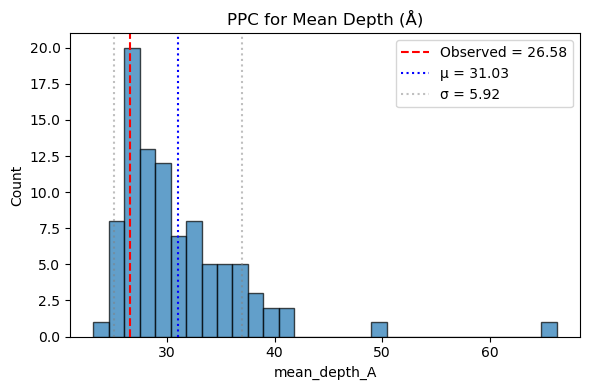

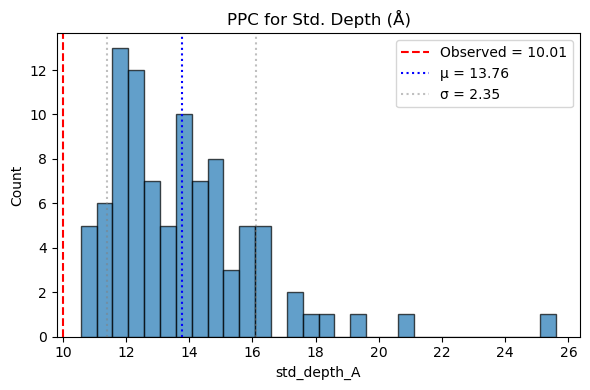

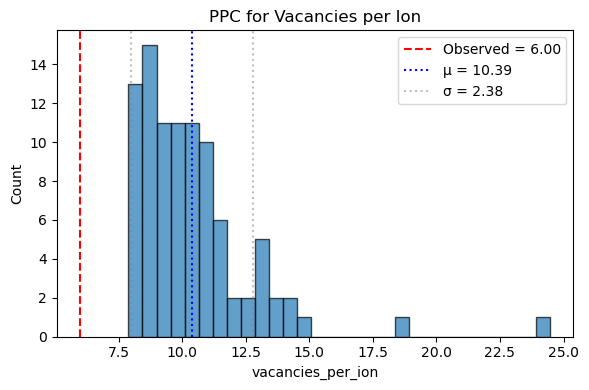

In [ ]:
#visualize PPC
plot_ppc_histograms(df, observed, bins=30)

## Conclusion

Simulation-Based Inference shows potential for estimating ion implantation parameters from damage profiles, offering a flexible and efficient alternative to standard fitting methods.The results from this run show a reasonable match between observed features and posterior predictive checks, suggesting the method is learning useful patterns but still has room to improve. Next steps include adding more parameters (angle, ion type, layer material), improving the neural density estimator, applying Simulation-Based Calibration (SBC) for validation, and running larger simulation sets for stronger results.
